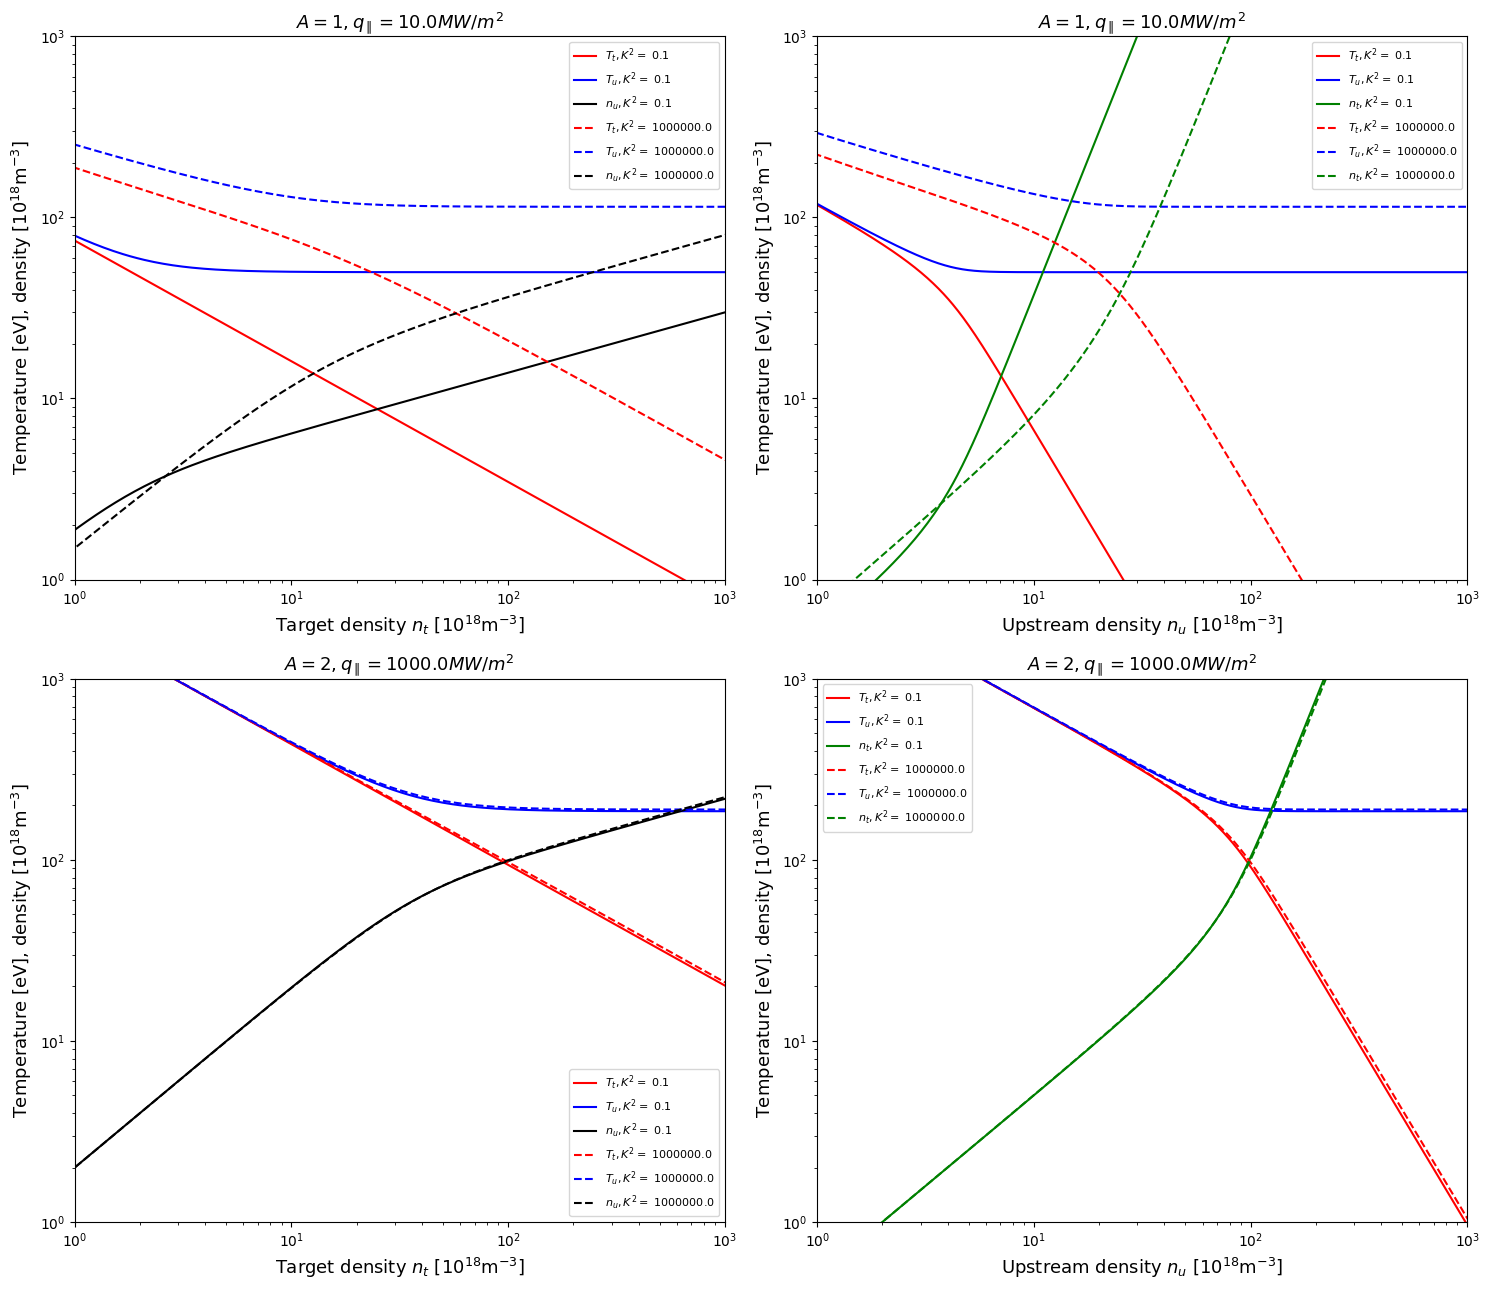

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

@nb.jit
def find_qt(nt, K2, gamma_hat, q):
    qt_init = q-1000.0 #arbitrary
    qt_guess = qt_init
    Tt_guess = np.power((qt_guess/gamma_hat/(nt*1e18)), 2/3)/e
    Tu_guess = np.power((np.power(Tt_guess, 7/2) + 3.5*qt_guess*Lz/a + (63/44)*(np.power(Tt_guess,2) * Lz * a * K2)/qt_guess)/((9/11) + (2*q)/(11*qt_guess)),2/7)
    qt_new = q + (7/4)*a*K2*Lz*(np.power(Tu_guess, 2) - np.power(Tt_guess,2))/(np.power(Tu_guess, 3.5) - np.power(Tt_guess,3.5))
    
    N = 1
    #print(qt_guess - qt_new, qt_new - q)
    while (np.abs(qt_guess - qt_new) > 1e-14) and (N < 1000):
        qt_guess = qt_new
        Tt_guess = np.power((qt_guess/gamma_hat/(nt*1e18)), 2/3)/e
        Tu_guess = np.power((np.power(Tt_guess, 7/2) + 3.5*qt_guess*Lz/a + (63/44)*(np.power(Tt_guess,2) * Lz * a * K2)/qt_guess)/((9/11) + (2*q)/(11*qt_guess)),2/7)
        qt_new = q + (7/4)*a*K2*Lz*(np.power(Tu_guess, 2) - np.power(Tt_guess,2))/(np.power(Tu_guess, 3.5) - np.power(Tt_guess,3.5))
        #print(qt_guess - qt_new, qt_new - q)
        N += 1
    
    return qt_new, Tt_guess, Tu_guess

@nb.jit
def get_results(nt, K2, gamma_hat, q):
    qt = np.zeros_like(nt)
    Tt = np.zeros_like(nt)
    Tu = np.zeros_like(nt)

    for i in range(0,len(nt)):
        qt[i], Tt[i], Tu[i] = find_qt(nt[i], K2, gamma_hat, q)

    nu = 2*nt*Tt/Tu

    return Tt, Tu, nu, qt

a = 2.0e3 # [W/m eV^-7/2]
Lz = 50.0 # [m]
m = np.array([1.67e-27, 1.67e-27 * 2])# [kg] 
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
heat_flux = np.array([1e7, 1e9]) # [W/m2]
K_sqr = np.array([0.1, 1e6])

N = int(1e3)

nt = np.logspace(-1, 10, N)
qt = np.zeros((8, N))
Tt = np.zeros((8, N))
Tu = np.zeros((8, N))
nu = np.zeros((8, N))

index = 0
for i2 in range(2):
    for i3 in range(2):
        Tt[index], Tu[index], nu[index], qt[index] = get_results(nt, K_sqr[i3], gamma_hat[i2], heat_flux[i2])
        index += 1

plt.figure(figsize=(15, 13))
for dashed in range(2):
    for index in range(1, 5):
        plt.subplot(2, 2, index)
        if dashed == 0:
            if np.mod(index, 2) == 1:
                plt.loglog(nt, Tt[(index - 1) // 2 * 2+dashed], color = 'r', label = f'$T_t, K^2 =$ {K_sqr[dashed]}')
                plt.loglog(nt, Tu[(index - 1) // 2 * 2+dashed], color = 'b', label = f'$T_u, K^2 =$ {K_sqr[dashed]}')
                plt.loglog(nt, nu[(index - 1) // 2 * 2+dashed], color = 'black', label = f'$n_u, K^2 =$ {K_sqr[dashed]}')
                plt.legend(fontsize = 8)
                plt.ylim(1, 1e3)
                plt.xlim(1, 1e3)
                plt.ylabel("Temperature [eV], density [$10^{18}$m$^{-3}$]", fontsize = 13)
                plt.xlabel("Target density $n_t$ [$10^{18}$m$^{-3}$]", fontsize = 13)
                plt.title(f'$A = {(index - 1) // 2 + 1}, q_\parallel = {heat_flux[(index - 1) // 2]/1e6} MW/m^2 $', fontsize = 13)
            elif np.mod(index, 2) == 0:
                plt.loglog(nu[(index - 1) // 2 * 2+dashed], Tt[(index - 1) // 2 * 2+dashed], color = 'r', label = f'$T_t, K^2 =$ {K_sqr[dashed]}')
                plt.loglog(nu[(index - 1) // 2 * 2+dashed], Tu[(index - 1) // 2 * 2+dashed], color = 'b', label = f'$T_u, K^2 =$ {K_sqr[dashed]}')
                plt.loglog(nu[(index - 1) // 2 * 2+dashed], nt, color = 'g', label = f'$n_t, K^2 =$ {K_sqr[dashed]}')
                plt.legend(fontsize = 8)
                plt.ylim(1, 1e3)
                plt.xlim(1, 1e3)
                plt.ylabel("Temperature [eV], density [$10^{18}$m$^{-3}$]", fontsize = 13)
                plt.xlabel("Upstream density $n_u$ [$10^{18}$m$^{-3}$]", fontsize = 13)
                plt.title(f'$A = {(index - 1) // 2 + 1}, q_\parallel = {heat_flux[(index - 1) // 2]/1e6} MW/m^2 $', fontsize = 13)
        if dashed == 1:
            if np.mod(index, 2) == 1:
                plt.loglog(nt, Tt[(index - 1) // 2 * 2+dashed], color = 'r', linestyle = 'dashed', label = f'$T_t, K^2 =$ {K_sqr[dashed]}')
                plt.loglog(nt, Tu[(index - 1) // 2 * 2+dashed], color = 'b', linestyle = 'dashed', label = f'$T_u, K^2 =$ {K_sqr[dashed]}')
                plt.loglog(nt, nu[(index - 1) // 2 * 2+dashed], color = 'black', linestyle = 'dashed', label = f'$n_u, K^2 =$ {K_sqr[dashed]}')
                plt.legend(fontsize = 8)
            elif np.mod(index, 2) == 0:
                plt.loglog(nu[(index - 1) // 2 * 2+dashed], Tt[(index - 1) // 2 * 2+dashed], linestyle = 'dashed',  color = 'r', label = f'$T_t, K^2 =$ {K_sqr[dashed]}')
                plt.loglog(nu[(index - 1) // 2 * 2+dashed], Tu[(index - 1) // 2 * 2+dashed], linestyle = 'dashed',  color = 'b', label = f'$T_u, K^2 =$ {K_sqr[dashed]}')
                plt.loglog(nu[(index - 1) // 2 * 2+dashed], nt, color = 'g', linestyle = 'dashed',  label = f'$n_t, K^2 =$ {K_sqr[dashed]}')
                plt.legend(fontsize = 8)

plt.tight_layout()
plt.show()